# Try spatial covariance and compare it with other variance calculation methods
Looks at how many standard deviations the sensed value is from the user labeled value.
Calculate variance by summing trip level variances and including a spatial covariance term based on trip clusters.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID

import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/mallen2/alternate_branches/gis-with-build-label-model/e-mission-server')

import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.decorations.trip_queries as esdtq
import emission.core.wrapper.user as ecwu

import confusion_matrix_handling as cm_handling
from confusion_matrix_handling import MODE_MAPPING_DICT
import get_EC
import helper_functions as hf

import sklearn.model_selection as skm

from sklearn.model_selection import KFold
from sklearn import linear_model

# import folium

# For fetching the trip clusters
import emission.analysis.modelling.trip_model.model_storage as eamtm
import emission.analysis.modelling.trip_model.model_type as eamum

METERS_TO_MILES = 0.000621371 # 1 meter = 0.000621371 miles
ECAR_PROPORTION = 0 #0.01 #~1% of cars on the road are electric.
DROVE_ALONE_TO_SHARED_RIDE_RATIO = 1

df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv') # r stands for raw string, only matters if the path is on Windows

storage not configured, falling back to sample, default configuration
URL not formatted, defaulting to "Stage_database"
Connecting to database URL localhost
The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do m

In [2]:
# If you already ran store_expanded_labeled_trips.ipynb already and want to save time vs running the cell below
%store -r expanded_labeled_trips

In [3]:
'''import database_related_functions as drf  # all the emission server functions for this notebook are in here.
user_list, os_map, uuid_program_map = drf.get_participants_programs_and_operating_systems()
#print(len(user_list), len(os_map), len(uuid_program_map))

# Takes ~ 1 min 45 s to 2 min 45 s on Macbook Pro for all ceo data up to May 2022.
expanded_labeled_trips = drf.get_expanded_labeled_trips(user_list)
expanded_labeled_trips['os'] = expanded_labeled_trips.user_id.map(os_map)
expanded_labeled_trips['program'] = expanded_labeled_trips['user_id'].map(uuid_program_map)

expanded_labeled_trips = expanded_labeled_trips.drop(labels = ['source', 'end_fmt_time', 'end_loc', 'raw_trip',
    'start_fmt_time', 'start_loc','start_local_dt_year', 'start_local_dt_month', 'start_local_dt_day',
    'start_local_dt_hour', 'start_local_dt_minute', 'start_local_dt_second',
    'start_local_dt_weekday', 'start_local_dt_timezone',
    'end_local_dt_year', 'end_local_dt_month', 'end_local_dt_day',
    'end_local_dt_hour', 'end_local_dt_minute', 'end_local_dt_second',
    'end_local_dt_weekday', 'end_local_dt_timezone'], axis = 1)

expanded_labeled_trips['distance_miles'] = expanded_labeled_trips.distance*METERS_TO_MILES

# Group together the prepilot participants
prepilot_list = ['84Q9SsrH','cwZazZLJ','CudLAeg8','sxxcLqbK','Q8T7QTXK','5KEGHHuf','e9MaNVU7','7c797MRD','rhBZukxY','k36cxmfA','FmxVf8u6','F3jxHLSW']
expanded_labeled_trips['program'] = expanded_labeled_trips.program.replace(prepilot_list, "prepilot")'''

'import database_related_functions as drf  # all the emission server functions for this notebook are in here.\nuser_list, os_map, uuid_program_map = drf.get_participants_programs_and_operating_systems()\n#print(len(user_list), len(os_map), len(uuid_program_map))\n\n# Takes ~ 1 min 45 s to 2 min 45 s on Macbook Pro for all ceo data up to May 2022.\nexpanded_labeled_trips = drf.get_expanded_labeled_trips(user_list)\nexpanded_labeled_trips[\'os\'] = expanded_labeled_trips.user_id.map(os_map)\nexpanded_labeled_trips[\'program\'] = expanded_labeled_trips[\'user_id\'].map(uuid_program_map)\n\nexpanded_labeled_trips = expanded_labeled_trips.drop(labels = [\'source\', \'end_fmt_time\', \'end_loc\', \'raw_trip\',\n    \'start_fmt_time\', \'start_loc\',\'start_local_dt_year\', \'start_local_dt_month\', \'start_local_dt_day\',\n    \'start_local_dt_hour\', \'start_local_dt_minute\', \'start_local_dt_second\',\n    \'start_local_dt_weekday\', \'start_local_dt_timezone\',\n    \'end_local_dt_year\'

In [4]:
unit_dist_MCS_df = pd.read_csv("unit_distance_MCS.csv").set_index("moment")
energy_dict = cm_handling.get_energy_dict(df_EI)

In [5]:
expanded_labeled_trips = hf.drop_unwanted_trips(expanded_labeled_trips, drop_not_a_trip=False)
# If you want to double check whether you included not a trip: 'not_a_trip' in expanded_labeled_trips.mode_confirm.unique()

expanded_labeled_trips = hf.get_primary_modes(expanded_labeled_trips,energy_dict,MODE_MAPPING_DICT)

Dropping user labeled AIR trips and trips with no OS.
Dropped 93 trips with no sensed sections.


Histogram of cluster size:


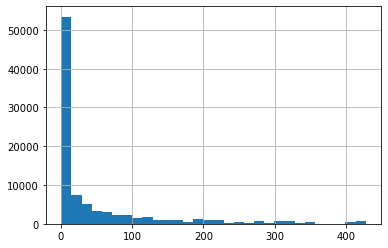

In [6]:
# Assign each trip to a cluster. Takes 26 minutes on all ceo up to the end of all ceo.
# First you need to find the clusters with build_label_model.py.
# (the script in e-mission-server that does the greedy similarity binning)
# source .../e-mission-py.bash  bin/build_label_model.py -a   (-a is for all users)

# start with the dataframe of the trips that we are interested in.
############## Make sure that this is a precomputation if you decide to use spatial covariance.###############

#expanded_labeled_trips = expanded_labeled_trips.set_index('_id')
expanded_labeled_trips['cluster_id'] = ['0']*len(expanded_labeled_trips)
expanded_labeled_trips['trip_neighbors'] = [['0']]*len(expanded_labeled_trips)
expanded_labeled_trips['cluster_size'] = ['0']*len(expanded_labeled_trips)

for user_id in expanded_labeled_trips.user_id.unique():
    # get the cluster for this user
    user_trip_clusters = eamtm.load_model(user_id, eamum.ModelType.GREEDY_SIMILARITY_BINNING, eamtm.ModelStorage.DOCUMENT_DATABASE)
    if user_trip_clusters is not None:
        for cluster_number in user_trip_clusters.keys():
            trips_in_cluster = user_trip_clusters[cluster_number]['trip_ids']  # want trips such that they are in the cluster and in the dataframe.
            relevant_trip_indices = expanded_labeled_trips[expanded_labeled_trips['_id'].isin(trips_in_cluster)].index

            trips_in_cluster_and_df = expanded_labeled_trips.loc[relevant_trip_indices]['_id']

            # Set the cluster number for all trips in the current cluster.

            for idx, trip_id in zip(relevant_trip_indices,trips_in_cluster):
                expanded_labeled_trips.loc[idx,'cluster_id'] = str(user_id) + '_' + cluster_number

                expanded_labeled_trips.loc[idx,'cluster_size'] = len(trips_in_cluster_and_df)

                # set a trip's neighbors as all cluster members excluding itself.
                expanded_labeled_trips.at[idx,'trip_neighbors'] = set(trips_in_cluster_and_df).difference({trip_id})
    else:
        user_index = expanded_labeled_trips[expanded_labeled_trips.user_id == user_id].index
        expanded_labeled_trips.loc[user_index, ['cluster_id', 'cluster_size']] = '1',1

        #expanded_labeled_trips.loc[relevant_trip_indices,'cluster_id'] = str(user_id) + '_' + cluster_number # cluster number is a string

print("Histogram of cluster size:")
expanded_labeled_trips.cluster_size.hist(bins=30); plt.show()

In [7]:
# extra packages I installed but ultimately didn't use. # shapely; geopandas; pysal

In [8]:
# To save time if you want to run this notebook again:
#all_ceo_with_clusters_expanded_labeled_trips = expanded_labeled_trips.copy()
#%store all_ceo_with_clusters_expanded_labeled_trips

In [9]:
'''%store -r all_ceo_with_clusters_expanded_labeled_trips
expanded_labeled_trips = all_ceo_with_clusters_expanded_labeled_trips.copy()
del all_ceo_with_clusters_expanded_labeled_trips'''

'%store -r all_ceo_with_clusters_expanded_labeled_trips\nexpanded_labeled_trips = all_ceo_with_clusters_expanded_labeled_trips.copy()\ndel all_ceo_with_clusters_expanded_labeled_trips'

In [10]:
# A look at how many trips are in clusters rather than just one time trips.
number_of_clustered_trips = len(expanded_labeled_trips[expanded_labeled_trips.cluster_size > 1])
number_of_single_trips = len(expanded_labeled_trips)-number_of_clustered_trips

print(number_of_clustered_trips, number_of_single_trips)

72630 19604


In [11]:
# Get the confusion matrices and then the EI moments from those.
android_confusion = pd.read_csv("android_confusion.csv").set_index('gt_mode')
ios_confusion = pd.read_csv("ios_confusion.csv").set_index('gt_mode')

android_confusion = cm_handling.collapse_confusion_matrix(android_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})
ios_confusion = cm_handling.collapse_confusion_matrix(ios_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})

sensed_car_EI = hf.find_sensed_car_energy_intensity(energy_dict, ECAR_PROPORTION, DROVE_ALONE_TO_SHARED_RIDE_RATIO)
energy_dict.update({"Car, sensed": sensed_car_EI})
expanded_labeled_trips['distance_miles'] = expanded_labeled_trips.distance*METERS_TO_MILES
EI_length_cov = 0

In [12]:
# if you forget this step, the error for expected may be different, 
# since you might be relying on a different saved version of the EI_moments_dataframe
android_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(android_confusion,energy_dict)
ios_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(ios_confusion,energy_dict)
os_EI_moments_map = {'ios': ios_EI_moments_df, 'android': android_EI_moments_df}
energy_consumption_df = get_EC.compute_all_EC_values(expanded_labeled_trips,unit_dist_MCS_df,energy_dict,android_EI_moments_df,ios_EI_moments_df, \
    EI_length_cov, print_info=False)

Computing energy consumption for each trip.
Using EI length covariance = 0.


In [13]:
# Demonstration of finding a spatial covariance for vail.
get_EC.spatial_autocov_based_on_clusters(energy_consumption_df[energy_consumption_df.program == 'vail'],'user_labeled', print_statistics=True)

Moran's I for user_labeled: 0.019
spatial autocovariance: 14.092


(14.091675022879702, 0.019421833294821434)

### Find the spatial autocovariance specific to each user.

In [14]:
# Takes 3 minutes on the full CEO dataset.
user_spatial_cov_map = {}
user_morans_I_map = {}
for user in energy_consumption_df.user_id.unique():
    user_df = energy_consumption_df[energy_consumption_df.user_id == user].copy()
    if len(user_df) < 2: 
        user_spatial_cov_map[user] = 0
        morans_I = 0
    else:
        user_spatial_cov_map[user], morans_I = get_EC.spatial_autocov_based_on_clusters(user_df, 'expected')
    user_morans_I_map[user] = morans_I

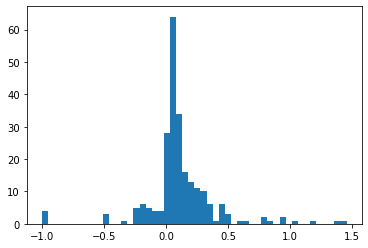

In [15]:
plt.hist(user_morans_I_map.values(), bins = 50)
plt.show()

In [16]:
# Double checking that I didn't include a trip in the list of its neighbors
mistaken_extra_ids = []
for i,ct in energy_consumption_df.iterrows():
    if ct['_id'] in ct['trip_neighbors']:
        print('trip should not be counted as one of its neighbors.')
        mistaken_extra_ids.append(ct['_id'])

# looks like a few slipped through somehow

trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.
trip should not be counted as one of its neighbors.


In [17]:
# What happens if we use the same spatial covariance value for all users? # Takes 1 min 15 s
'''cov_sum = 0
for cluster_id in energy_consumption_df.cluster_id.unique():
    cluster_size = len(energy_consumption_df[energy_consumption_df.cluster_id == cluster_id])
    if cluster_size > 1:
        cov_sum += 15.504*(cluster_size**2 - cluster_size)  # I calculated a CEO dataset wide spatial cov of 15.504
larger_sd = np.sqrt(energy_consumption_df.confusion_var.sum() + cov_sum)
print(f"aggregate standard deviation: {larger_sd}")
error = energy_consumption_df.expected.sum() - energy_consumption_df.user_labeled.sum()
print(f"Error for expected: {error:.2f}")'''

aggregate standard deviation: 9033.219444614862
Error for expected: 65720.61


In [18]:
# What happens if Moran's I is maxed out for each participant, leading to just adding the variance for each user in each cluster?
# Concretely, instead of using the autocovariance that I calculated for each user, I would just use the variance of expected EI estimates calculated for each user.
'''from math import factorial
def n_choose_r(n,r):
    return factorial(n)/(factorial(r)*factorial(n-r))

user_variance_map = {}
for user in energy_consumption_df.user_id.unique():
    user_df = energy_consumption_df[energy_consumption_df.user_id == user].copy()
    user_variance_map[user] = np.var(user_df.expected)

max_cov_sum = 0
for user in energy_consumption_df.user_id.unique():
    # Get the trips associated with this user.
    user_df = energy_consumption_df[energy_consumption_df.user_id == user].copy()
    for cluster_id in user_df.cluster_id.unique():
        cluster_size = len(user_df[user_df.cluster_id == cluster_id])
        if cluster_size > 1:
            max_cov_sum += 2*user_variance_map[user]*n_choose_r(cluster_size,2)  # I later switched to n**2 - n.  2* n_choose_2 == n**2 - n. 

max_spatial_cov_sd = np.sqrt(energy_consumption_df.confusion_var.sum() + max_cov_sum)
print(f"aggregate standard deviation: {max_spatial_cov_sd}")
error = energy_consumption_df.expected.sum() - energy_consumption_df.user_labeled.sum()
print(f"Error for expected: {error:.2f}")'''

'from math import factorial\ndef n_choose_r(n,r):\n    return factorial(n)/(factorial(r)*factorial(n-r))\n\nuser_variance_map = {}\nfor user in energy_consumption_df.user_id.unique():\n    user_df = energy_consumption_df[energy_consumption_df.user_id == user].copy()\n    user_variance_map[user] = np.var(user_df.expected)\n\nmax_cov_sum = 0\nfor user in energy_consumption_df.user_id.unique():\n    # Get the trips associated with this user.\n    user_df = energy_consumption_df[energy_consumption_df.user_id == user].copy()\n    for cluster_id in user_df.cluster_id.unique():\n        cluster_size = len(user_df[user_df.cluster_id == cluster_id])\n        if cluster_size > 1:\n            max_cov_sum += 2*user_variance_map[user]*n_choose_r(cluster_size,2)  # I later switched to n**2 - n.  2* n_choose_2 == n**2 - n. \n\nmax_spatial_cov_sd = np.sqrt(energy_consumption_df.confusion_var.sum() + max_cov_sum)\nprint(f"aggregate standard deviation: {max_spatial_cov_sd}")\nerror = energy_consumption

In [19]:
larger_sd = np.sqrt(get_EC.compute_variance_including_spatial_cov_for_trips_dataframe(energy_consumption_df,user_spatial_cov_map))
print(f"aggregate standard deviation: {larger_sd}")
error = energy_consumption_df.expected.sum() - energy_consumption_df.user_labeled.sum()
print(f"Error for expected: {error:.2f}")

aggregate standard deviation: 11183.98395721003
Error for expected: 65720.61


In [20]:
energy_consumption_from_primary_mode_df = get_EC.compute_all_EC_values_from_primary_mode(expanded_labeled_trips, unit_dist_MCS_df, energy_dict, android_EI_moments_df,ios_EI_moments_df)

Computing energy consumption for each trip.


### Compare standard errors between variance calculation methods

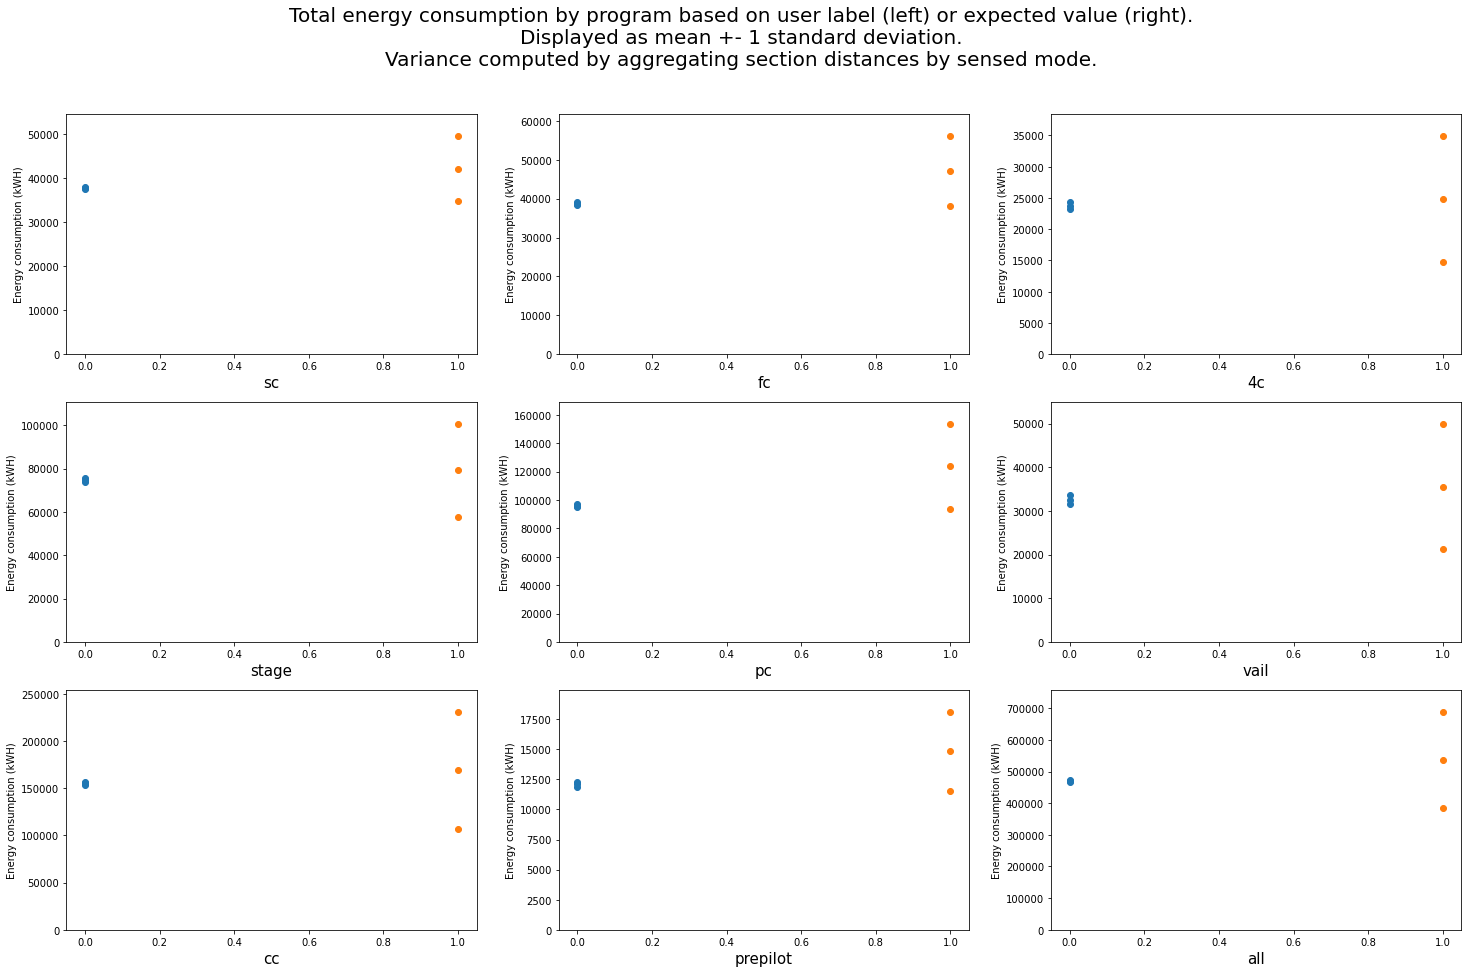

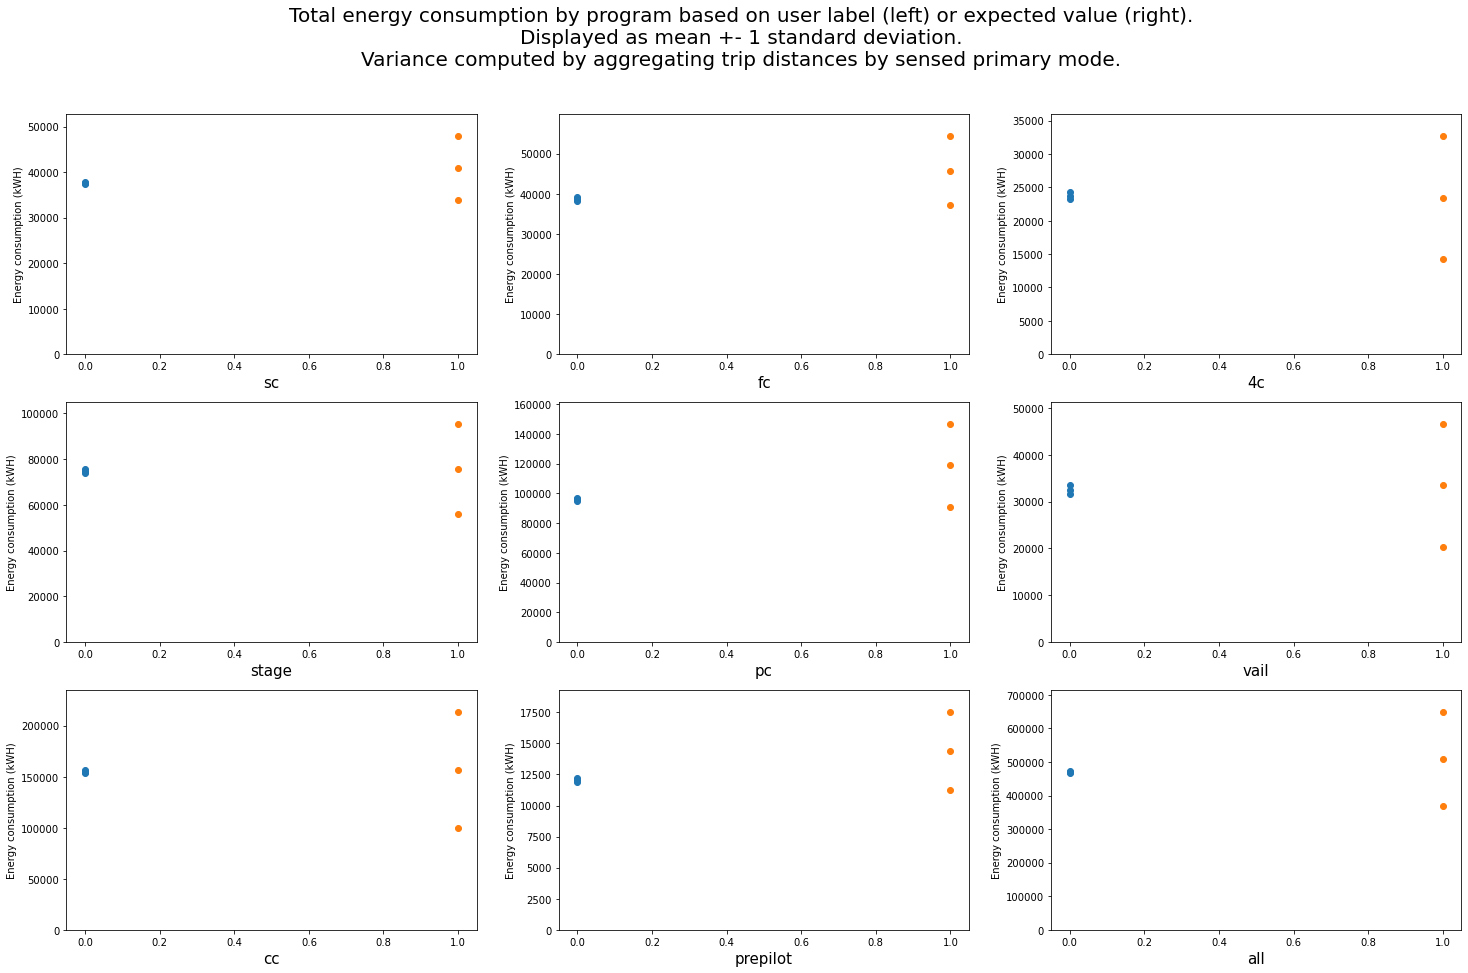

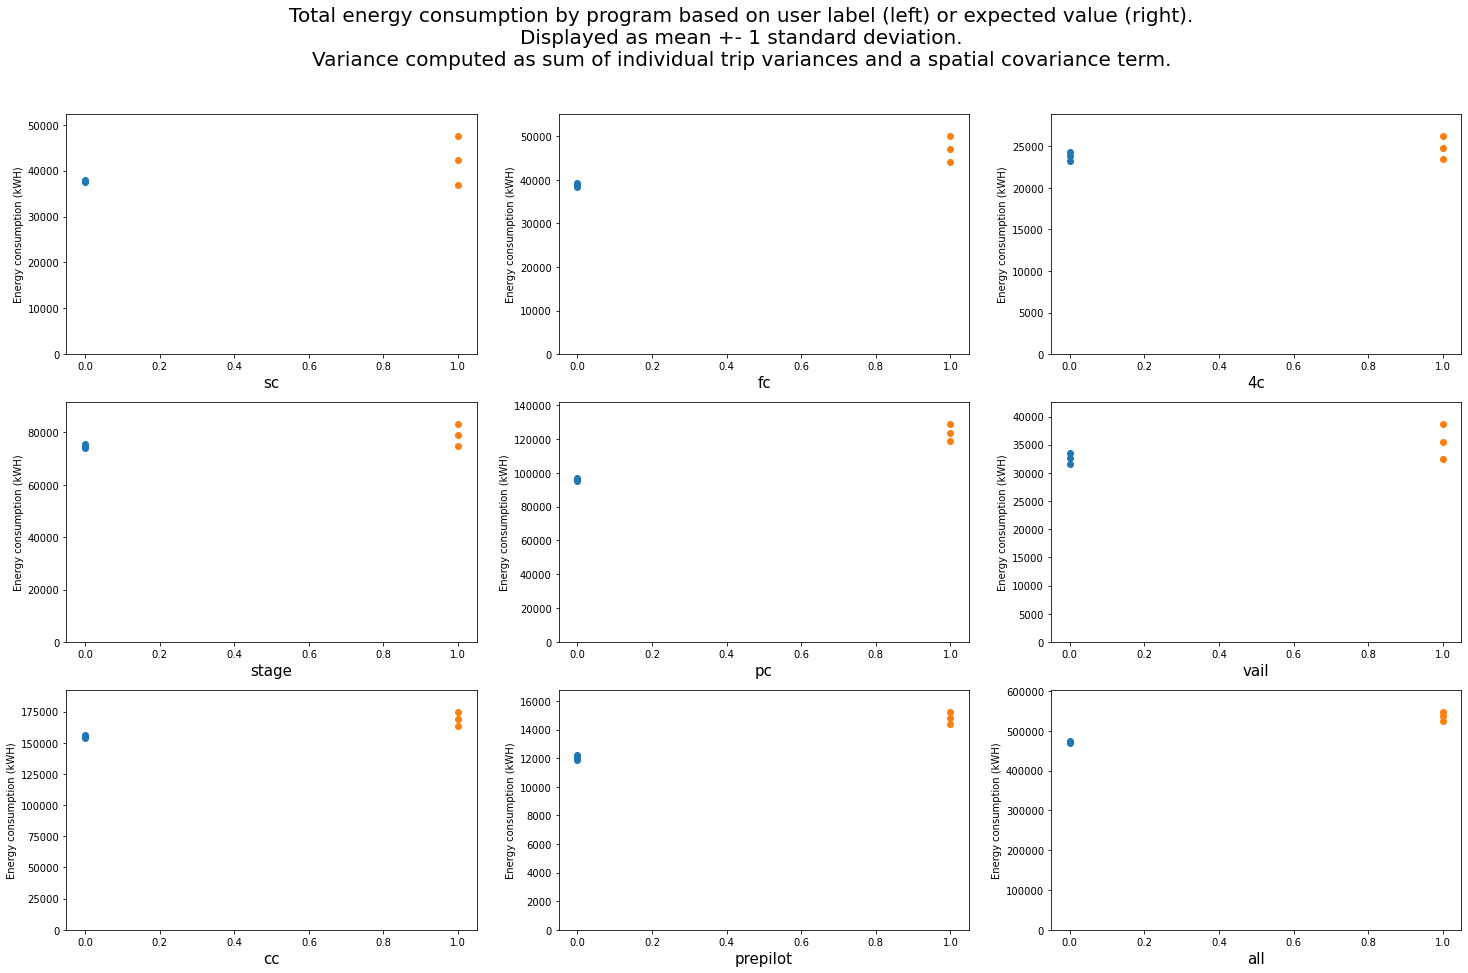

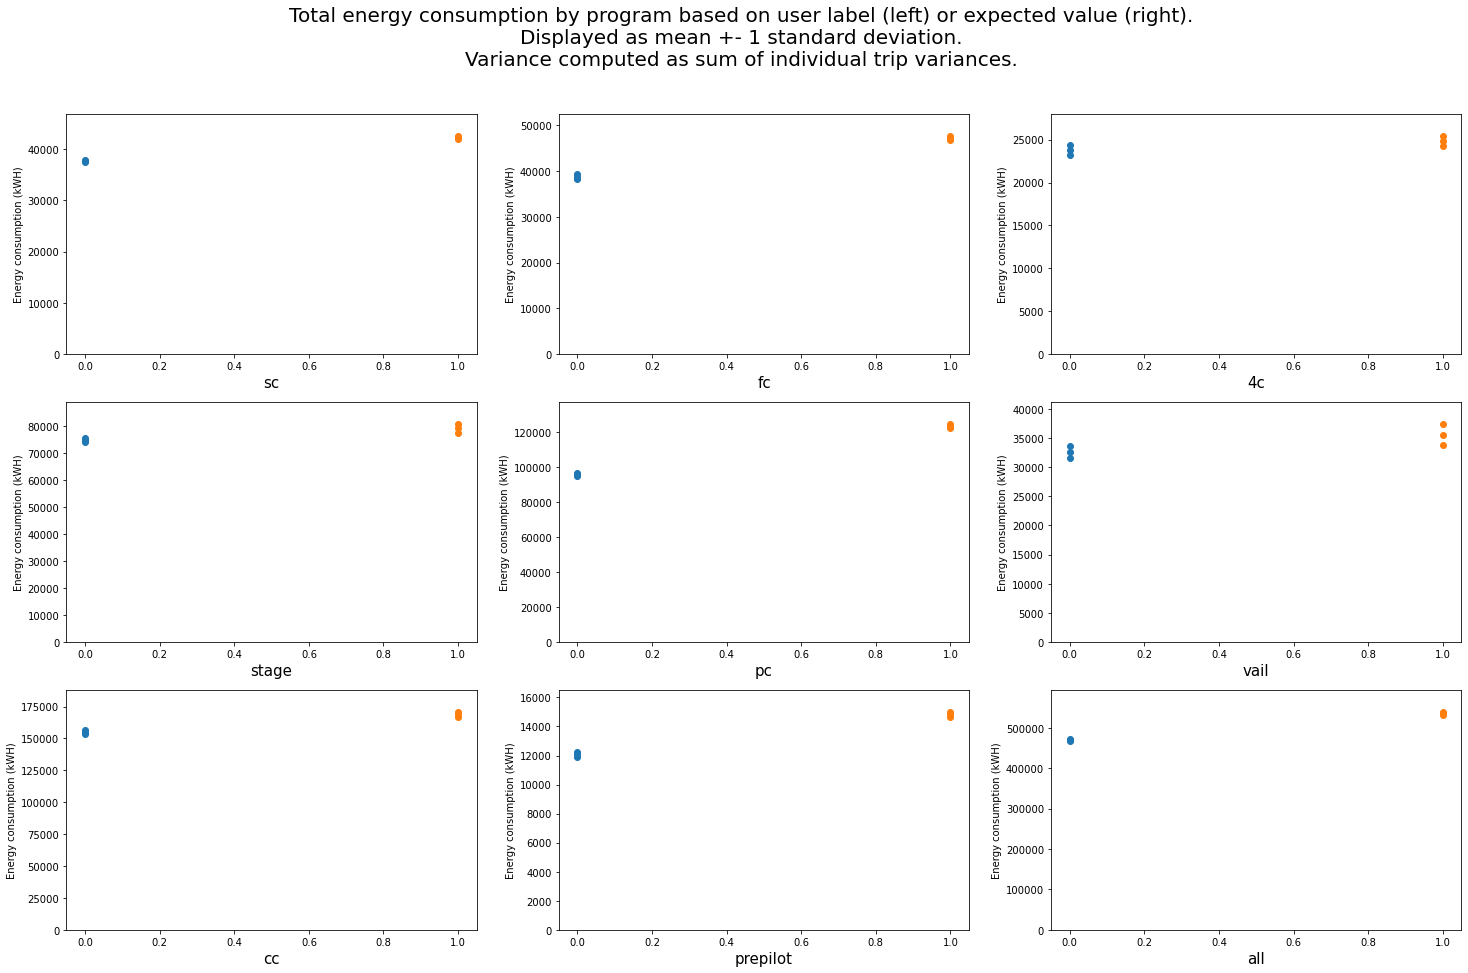

In [21]:
program_n_sd_map_agg_distance = hf.plot_estimates_with_sd_by_program(energy_consumption_df,os_EI_moments_map,unit_dist_MCS_df, variance_method='aggregate_section_distances', user_spatial_cov_map = user_spatial_cov_map)
program_n_sd_map_agg_primary_mode_distance = hf.plot_estimates_with_sd_by_program(energy_consumption_from_primary_mode_df,os_EI_moments_map,unit_dist_MCS_df, variance_method='aggregate_primary_mode_distances', user_spatial_cov_map = user_spatial_cov_map)
program_n_sd_map_spatial_cov = hf.plot_estimates_with_sd_by_program(energy_consumption_df,os_EI_moments_map,unit_dist_MCS_df, variance_method='spatial_cov', user_spatial_cov_map = user_spatial_cov_map)
program_n_sd_map_individual = hf.plot_estimates_with_sd_by_program(energy_consumption_df,os_EI_moments_map,unit_dist_MCS_df, variance_method='independent', user_spatial_cov_map = user_spatial_cov_map)

In [22]:
n_sd_df = pd.DataFrame([program_n_sd_map_agg_distance, program_n_sd_map_agg_primary_mode_distance, program_n_sd_map_spatial_cov,program_n_sd_map_individual])
print(n_sd_df.rename(index = {0:'Aggregate Section Distance', 1: 'Aggregate Primary Mode Distance', 2:'Spatial Covariance', 3:'Independent Trips'}).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &     sc &     fc &    4c &  stage &     pc &  vail &    cc &  prepilot &    all \\
\midrule
Aggregate Section Distance      &   0.61 &   0.93 &  0.11 &   0.20 &   0.93 &  0.21 &  0.22 &      0.84 &   0.43 \\
Aggregate Primary Mode Distance &   0.45 &   0.81 &  0.03 &   0.04 &   0.82 &  0.07 &  0.03 &      0.74 &   0.27 \\
Spatial Covariance              &   0.86 &   2.86 &  0.79 &   1.03 &   5.52 &  0.96 &  2.37 &      6.53 &   5.88 \\
Independent Trips               &  15.36 &  18.04 &  1.93 &   2.56 &  27.10 &  1.64 &  7.15 &     15.21 &  19.27 \\
\bottomrule
\end{tabular}



### Plot estimates plus or minus one standard deviation for each program
The left dots in each plot are for user labeled values.
The right three dots in each plot are expected aka confusion based values.

{'sc': 0.86, 'fc': 2.86, '4c': 0.79, 'stage': 1.03, 'pc': 5.52, 'vail': 0.96, 'cc': 2.37, 'prepilot': 6.53, 'all': 5.88}


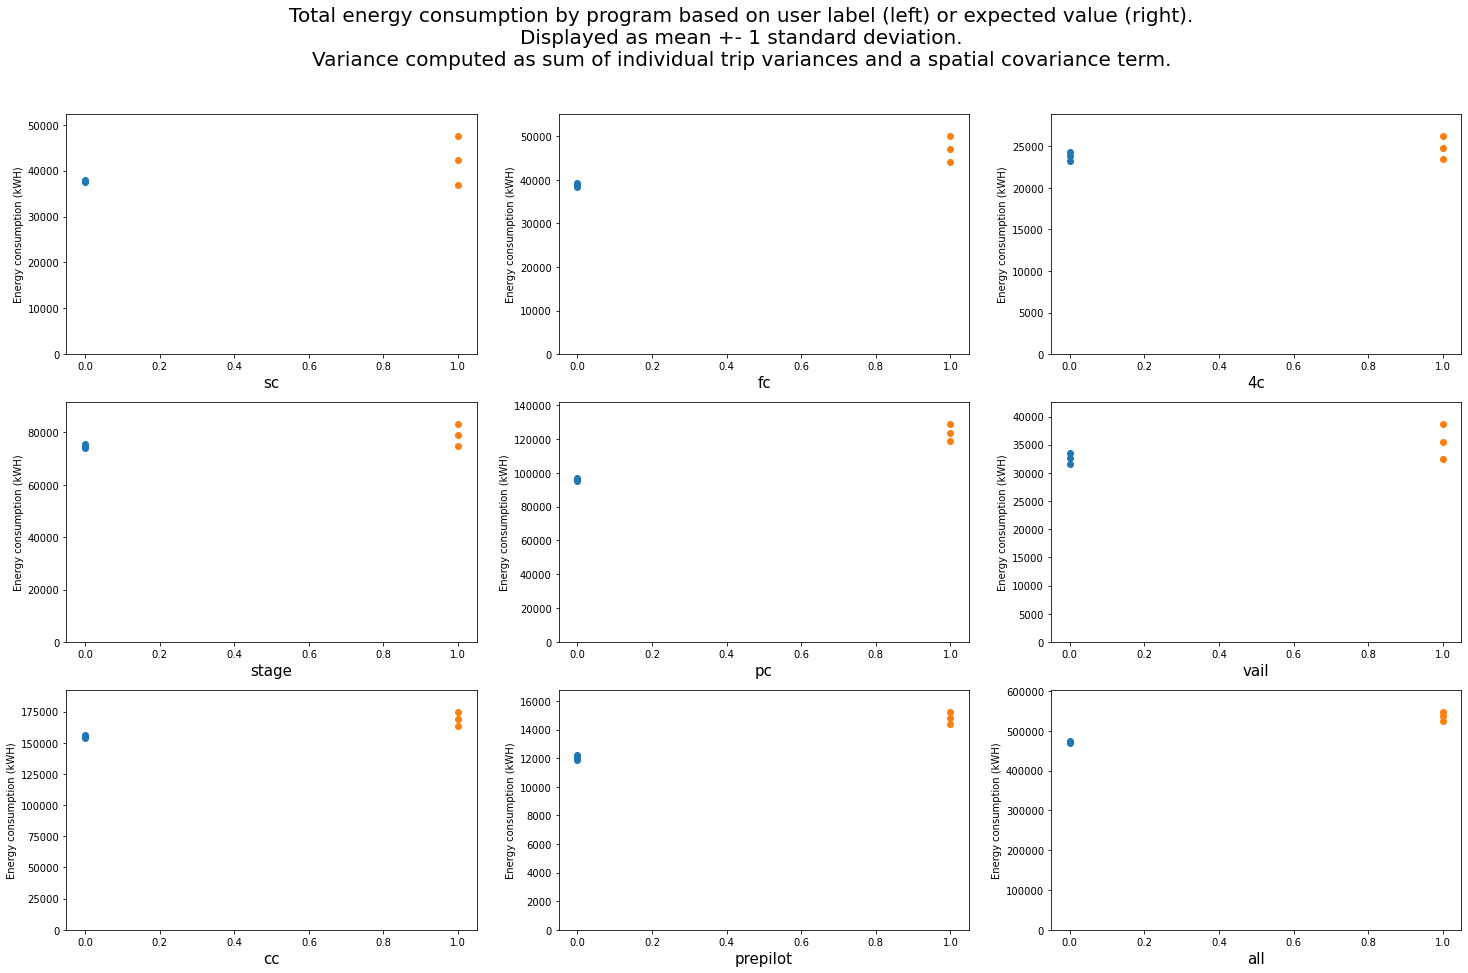

In [23]:
# This cell plots the user labeled and expected aggregate energy consumptions on the left and right, respectively.
# It finds aggregate variance by summing individual variances and adding a spatial covariance term.

program_n_sd_map = hf.plot_estimates_with_sd_by_program(energy_consumption_df,os_EI_moments_map,unit_dist_MCS_df, variance_method='spatial_cov', user_spatial_cov_map = user_spatial_cov_map)
print(program_n_sd_map)

## Try with Bayes update. 
### How does spatial covariance perform with different assumed mode distributions than that of MobilityNet?

In [24]:
prior_probs_prespecified = {"Car, sensed": 0.7, "Pilot ebike": 0.13}
prior_probs = prior_probs_prespecified.copy()
n_other_modes = len(android_confusion.index) - len(prior_probs_prespecified)
probability_remaining = 1 - sum(prior_probs_prespecified.values())
prior_probs.update({x: probability_remaining/n_other_modes for x in android_confusion.index if x not in prior_probs_prespecified.keys()})
#prior_probs = {x: 1/len(android_confusion.index) for x in android_confusion.index} # if you want a uniform prior.

android_EI_moments_with_Bayes_update_df = cm_handling.get_Bayesian_conditional_EI_expectation_and_variance(android_confusion,energy_dict, prior_probs)
ios_EI_moments_with_Bayes_update_df = cm_handling.get_Bayesian_conditional_EI_expectation_and_variance(ios_confusion,energy_dict, prior_probs)
os_EI_moments_with_Bayes_update_map = {'ios': ios_EI_moments_with_Bayes_update_df, 'android': android_EI_moments_with_Bayes_update_df}
energy_consumption_with_Bayes_update_df = get_EC.compute_all_EC_values(expanded_labeled_trips,unit_dist_MCS_df,energy_dict,\
    android_EI_moments_with_Bayes_update_df,\
    ios_EI_moments_with_Bayes_update_df, \
    EI_length_cov, print_info=False)

Computing energy consumption for each trip.
Using EI length covariance = 0.


## Looking for cases where mode inference errors are repeated.

#### Let's start by looking for ebike mispredicted as car.

In [ ]:
ebike_but_predicted_as_car = energy_consumption_df[(energy_consumption_df.mode_confirm == 'pilot_ebike') & (energy_consumption_df.primary_mode == 'car')]

In [ ]:
cluster_id = ebike_but_predicted_as_car.cluster_id.iloc[0]
ebike_but_predicted_as_car[ebike_but_predicted_as_car.cluster_id == cluster_id][['mode_confirm','primary_mode','distance_miles','expected','user_labeled']]
# even though these were the same mistake in the same cluster, the trips were different distances and so the energy consumption estimates were not very similar.

In [ ]:
# Lets try looking at a larger cluster. Turns out that large cluster does not guarantee a lot of repeated ebike car mistakes.
large_clusters = ebike_but_predicted_as_car[ebike_but_predicted_as_car.cluster_size > 50].cluster_id
ebike_but_predicted_as_car[ebike_but_predicted_as_car.cluster_id == large_clusters.iloc[1]][['mode_confirm','primary_mode','distance_miles','expected','user_labeled']]

#### Let's pick a cluster and look for common mistakes.

Be careful with these cells. Clear all outputs with locations before pushing to github

In [ ]:
'''large_clusters = energy_consumption_df[energy_consumption_df.cluster_size > 10].cluster_id
energy_consumption_df[energy_consumption_df.cluster_id == large_clusters.iloc[0]][['mode_confirm','primary_mode','distance_miles','expected','predicted','user_labeled']]'''

In [ ]:
'''large_clusters = energy_consumption_df[energy_consumption_df.cluster_size > 10].cluster_id
energy_consumption_df[(energy_consumption_df.cluster_id == large_clusters.iloc[0]) & (energy_consumption_df.primary_mode == 'car')][['mode_confirm','primary_mode','distance_miles','expected','predicted','user_labeled']]'''

In [ ]:
'''# lots of not a trips.
large_clusters = energy_consumption_df[energy_consumption_df.cluster_size > 50].cluster_id
cols_of_interest = ['mode_confirm','primary_mode','distance_miles','expected','predicted','user_labeled']
energy_consumption_df[(energy_consumption_df.cluster_id == large_clusters.iloc[13000]) & (energy_consumption_df.primary_mode == 'no_sensed')][cols_of_interest]'''

In [ ]:
def calculate_LISAs(df, col_of_interest):
    '''
    Outputs a Local Indicator of Spatial Association (LISA) for the col_of_interest. Specifically, it finds local Moran's I for each trip.
    See https://geographicdata.science/book/notebooks/07_local_autocorrelation.html for details. 
    The weights are based on cluster membership. If a trip is in the neighborhood of another (aka in the same cluster),
    the spatial weight is 1. Otherwise it is 0. Cluster membership is seen in the cluster_id or in the trip_neighbors columns.

    df: a trips dataframe that already has assigned clusters for each trip id.
    col_of_interest: a string label for the column to find spatial covariance from.
        eg, use 'expected' for sensing expected energy consumption estimates.

    Returns: a float representing the spatial autocovariance of the variable. 
        (I think) it should be between -1*v and 1*v, where v is the variance of the variable.
    '''
    n = len(df)
    xbar = np.mean(df[col_of_interest])
    var_x = np.var(df[col_of_interest])
    cov_sum = 0
    W_sum = 0 

    local_I = []

    for i,trip in df.iterrows():
            #if trip['cluster_size'] == 1: 
            #    local_I.append(0)
            #else:
            #neighbor_list = list(trip['trip_neighbors']) 
            # sometimes neighbor list will have neighbors that are not in the timeframe of interest, but neighbors_df will only have the trips of interest.
            neighbors_df = df[(df.cluster_id == trip['cluster_id']) & (df._id != trip['_id'])]#neighbors_df = energy_consumption_df[energy_consumption_df['_id'].isin(neighbor_list)].copy()

            if len(neighbors_df) == 0:
                local_I.append(0)
            else:
                # for each neighbor, multiply trip i's deviation from the mean by the neighbors deviation from the mean.
                # then sum:  ( sum_{j=1:n} w_{ij} (x_i - xbar)(x_j - xbar) )
                trip_i_deviation = trip[col_of_interest] - xbar   # scalar
                neighbor_deviations = neighbors_df[col_of_interest] - xbar  # array
                #print(trip_i_deviation)
                #print(neighbor_deviations)

                w = 1/len(neighbors_df) # normalize the weights
                local_I.append(w*sum(trip_i_deviation*neighbor_deviations)/var_x)

    return local_I

In [ ]:
large_clusters = energy_consumption_df[energy_consumption_df.cluster_size > 50].cluster_id

no_sensed_user = energy_consumption_df[(energy_consumption_df.cluster_id == large_clusters.iloc[13000])].user_id.iloc[0]
trips = energy_consumption_df[energy_consumption_df.user_id == no_sensed_user].copy()
LISAs_for_no_sensed_user = calculate_LISAs(trips,'expected')

trips['local_I'] = LISAs_for_no_sensed_user
trips[trips.cluster_id == large_clusters.iloc[13000]][cols_of_interest + ['cluster_id','local_I']] 
#trips[trips.local_I > 10].cluster_id

#spatial_autocov_based_on_clusters(trips,'expected')

In [ ]:
trips.cluster_size.hist(); plt.show()

In [ ]:
trips.local_I.hist(bins=40); plt.show()

In [ ]:
local_I_expected = calculate_LISAs(energy_consumption_df[energy_consumption_df.program == 'vail'],'expected')
local_I_predicted = calculate_LISAs(energy_consumption_df[energy_consumption_df.program == 'vail'],'predicted')
local_I_user_labeled = calculate_LISAs(energy_consumption_df[energy_consumption_df.program == 'vail'],'user_labeled')

### A look at the distribution of local I values that we get.

In [ ]:
import seaborn
ax = seaborn.kdeplot(local_I_expected)
seaborn.rugplot(local_I_expected, ax=ax) # adds bars for each observation

In [ ]:
ax = seaborn.kdeplot(local_I_user_labeled)
seaborn.rugplot(local_I_user_labeled, ax=ax) # adds bars for each observation

### Sanity check for the spatial autocorrelation with synthetic data.


In [ ]:
# columns: trip id, cluster id, primary mode, distance, energy consumption
# make a dataframe.
n_trips = 10**3
n_work_trips = int(0.70*n_trips)
n_grocery_trips = int(0.20*n_trips)
n_friend_trips = int(0.10*n_trips)

work_trip_length = 10 # miles
grocery_trip_length = 5
friend_trip_length = 20

fake_trips_df = pd.DataFrame({
    "_id": list(range(n_trips)),
    "cluster_id": ["0"]*n_work_trips + ["1"]*n_grocery_trips + ["2"]*n_friend_trips,
    "primary_mode": ["car"]*n_trips,
    "distance": [work_trip_length]*n_work_trips + [grocery_trip_length]*n_grocery_trips + [friend_trip_length]*n_friend_trips
})

r = 1 
car_load_factor = (r+1)/(r+0.5)
drove_alone_EI = energy_dict["Gas Car, drove alone"]
energy_dict.update({"Car, sensed": drove_alone_EI/car_load_factor})

fake_trips_df['predicted_EC'] = energy_dict['Car, sensed']*fake_trips_df['distance']
fake_trips_df['expected_EC'] = 1.1*fake_trips_df['distance']

spatial_autocov_based_on_clusters(fake_trips_df,'expected_EC', print_statistics=True)
spatial_autocov_based_on_clusters(fake_trips_df,'predicted_EC', print_statistics=True)
print(f"variance for predicted EC: {np.var(fake_trips_df.predicted_EC)}")

In [ ]:
fake_trips_df['local_I'] = calculate_LISAs(fake_trips_df,'predicted_EC')
fake_trips_df[fake_trips_df.cluster_id == "2"]

In [ ]:
# columns: trip id, cluster id, primary mode, distance, energy consumption
# make a dataframe.
n_trips = 10**3
n_work_trips = int(0.50*n_trips)
n_grocery_trips = int(0.30*n_trips)
n_friend_trips = int(0.20*n_trips)

work_trip_length = 10 # miles
grocery_trip_length = 5
friend_trip_length = 20

fake_trips_df = pd.DataFrame({
    "_id": list(range(n_trips)),
    "cluster_id": ["0"]*n_work_trips + ["1"]*n_grocery_trips + ["2"]*n_friend_trips,
    "primary_mode": ["car"]*n_trips,
    "distance": [work_trip_length]*n_work_trips + [grocery_trip_length]*n_grocery_trips + [friend_trip_length]*n_friend_trips
})

fake_trips_df['predicted_EC'] = energy_dict['Car, sensed']*fake_trips_df['distance']
spatial_autocov_based_on_clusters(fake_trips_df,'predicted_EC', print_statistics=True)
print(f"variance for predicted EC: {np.var(fake_trips_df.predicted_EC)}")

In [ ]:
# columns: trip id, cluster id, primary mode, distance, energy consumption
# make a dataframe.
n_trips = 10**3

n_work_trips = int(0.50*n_trips)
n_grocery_trips = int(0.30*n_trips)
n_friend_trips = int(0.10*n_trips)
n_recreation_trips = int(0.10*n_trips)

work_trip_length = 10 # miles
grocery_trip_length = 5
friend_trip_length = 20
recreation_trip_length = 40

fake_trips_df = pd.DataFrame({
    "_id": list(range(n_trips)),
    "cluster_id": ["0"]*n_work_trips + ["1"]*n_grocery_trips + ["2"]*n_friend_trips + ["3"]*n_recreation_trips,
    "primary_mode": ["Car, sensed"]*n_work_trips + ["Pilot ebike"]*n_grocery_trips + ["Car, sensed"]*n_friend_trips + ["Car, sensed"]*n_recreation_trips,
    "distance": [work_trip_length]*n_work_trips + [grocery_trip_length]*n_grocery_trips + [friend_trip_length]*n_friend_trips + [recreation_trip_length]*n_recreation_trips
})

fake_trips_df['predicted_EC'] = fake_trips_df.primary_mode.map(energy_dict)*fake_trips_df['distance']
spatial_autocov_based_on_clusters(fake_trips_df,'predicted_EC', print_statistics=True)
print(f"variance for predicted EC: {np.var(fake_trips_df.predicted_EC)}")

In [ ]:
# If highly homogeneous:
# columns: trip id, cluster id, primary mode, distance, energy consumption
# make a dataframe.
n_trips = 10**3

n_work_trips = int(0.90*n_trips)
n_grocery_trips = int(0.05*n_trips)
n_friend_trips = int(0.05*n_trips)
n_recreation_trips = int(0*n_trips)

work_trip_length = 10 # miles
grocery_trip_length = 5
friend_trip_length = 20
recreation_trip_length = 40

fake_trips_df = pd.DataFrame({
    "_id": list(range(n_trips)),
    "cluster_id": ["0"]*n_work_trips + ["1"]*n_grocery_trips + ["2"]*n_friend_trips + ["3"]*n_recreation_trips,
    "primary_mode": ["Car, sensed"]*n_work_trips + ["Pilot ebike"]*n_grocery_trips + ["Car, sensed"]*n_friend_trips + ["Car, sensed"]*n_recreation_trips,
    "distance": [work_trip_length]*n_work_trips + [grocery_trip_length]*n_grocery_trips + [friend_trip_length]*n_friend_trips + [recreation_trip_length]*n_recreation_trips
})

fake_trips_df['predicted_EC'] = fake_trips_df.primary_mode.map(energy_dict)*fake_trips_df['distance']
spatial_autocov_based_on_clusters(fake_trips_df,'predicted_EC', print_statistics=True)
print(f"variance for predicted EC: {np.var(fake_trips_df.predicted_EC)}")

In [ ]:
# columns: trip id, cluster id, primary mode, distance, energy consumption
# make a dataframe.
n_trips = 10**3

n_work_trips = int(0.30*n_trips)
n_grocery_trips = int(0.50*n_trips)
n_friend_trips = int(0.10*n_trips)
n_recreation_trips = int(0.10*n_trips)

work_trip_length = 10 # miles
grocery_trip_length = 5
friend_trip_length = 20
recreation_trip_length = 40

fake_trips_df = pd.DataFrame({
    "_id": list(range(n_trips)),
    "cluster_id": ["0"]*n_work_trips + ["1"]*n_grocery_trips + ["2"]*n_friend_trips + ["3"]*n_recreation_trips,
    "primary_mode": ["Car, sensed"]*n_work_trips + ["Pilot ebike"]*n_grocery_trips + ["Car, sensed"]*n_friend_trips + ["Car, sensed"]*n_recreation_trips,
    "distance": [work_trip_length]*n_work_trips + [grocery_trip_length]*n_grocery_trips + [friend_trip_length]*n_friend_trips + [recreation_trip_length]*n_recreation_trips
})

fake_trips_df['predicted_EC'] = fake_trips_df.primary_mode.map(energy_dict)*fake_trips_df['distance']
spatial_autocov_based_on_clusters(fake_trips_df,'predicted_EC', print_statistics=True)
print(f"variance for predicted EC: {np.var(fake_trips_df.predicted_EC)}")

In [ ]:
main_mode_confirms = ['drove_alone','shared_ride','walk','pilot_ebike','bus','bike','train','taxi','free_shuttle', 'not_a_trip']
main_modes_df = expanded_labeled_trips[expanded_labeled_trips.mode_confirm.isin(main_mode_confirms)].copy()
main_modes_df = main_modes_df[main_modes_df.mode_confirm.notna()]

match_count = 0
for _,ct in main_modes_df.iterrows():
    if (ct['primary_mode'] == 'car') and (ct['mode_confirm'] in ['shared_ride', 'taxi']):
        match_count += 1
    elif (ct['primary_mode'] == 'bicycling') and (ct['mode_confirm'] == 'pilot_ebike'):
        match_count += 1
    elif (ct['primary_mode'] == 'bus') and (ct['mode_confirm'] == 'free_shuttle'):
        match_count += 1
    elif MODE_MAPPING_DICT[ct['primary_mode']] == MODE_MAPPING_DICT[ct['mode_confirm']]:
        match_count += 1